# Stock Prediction

I am using this project to learn about the common techniques to manipulate time series data and make simple predictions.

The data is that I will be analysing is an ETF called ES3 that tracks the movement of the Straits Times Index (STI). The data was pulled from yahoo finance. Even though the ETF started in 2002, yahoo data only starts from 2008.

There roughly 3000 days of recoreded trading for ES3.

## Clean data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
DATAPATH = 'ES3.csv'

In [3]:
data = pd.read_csv(DATAPATH, index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,3.54730,3.54730,3.54730,3.54730,3.54730,0.0
2008-01-03,3.48305,3.48305,3.48305,3.48305,3.48305,0.0
2008-01-04,3.52404,3.52404,3.52404,3.52404,3.52404,0.0
2008-01-07,3.43901,3.43901,3.43901,3.43901,3.43901,0.0
2008-01-08,3.42421,3.42421,3.42421,3.42421,3.42421,0.0
2008-01-09,3.43010,3.43010,3.43010,3.43010,3.43010,0.0
2008-01-10,3.39695,3.39695,3.39695,3.39695,3.39695,0.0
2008-01-11,3.37321,3.37321,3.37321,3.37321,3.37321,0.0
2008-01-14,3.30373,3.30373,3.30373,3.30373,3.30373,0.0


In [4]:
data.shape

(3533, 6)

In [5]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [6]:
#data cleansing
print("Null Value Present: ", data.isnull().values.any())

Null Value Present:  True


In [7]:
data = data.dropna()
print(data.shape)

(3528, 6)


In [8]:
data[data.Volume==0]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,3.54730,3.54730,3.54730,3.54730,3.54730,0.0
2008-01-03,3.48305,3.48305,3.48305,3.48305,3.48305,0.0
2008-01-04,3.52404,3.52404,3.52404,3.52404,3.52404,0.0
2008-01-07,3.43901,3.43901,3.43901,3.43901,3.43901,0.0
2008-01-08,3.42421,3.42421,3.42421,3.42421,3.42421,0.0
...,...,...,...,...,...,...
2010-12-31,3.31000,3.31000,3.28000,3.28000,3.28000,0.0
2019-01-01,3.11700,3.11700,3.11700,3.11700,3.11700,0.0
2019-02-05,3.18200,3.18200,3.18200,3.18200,3.18200,0.0


In [9]:
#remove 0s in data
idx_to_remove = data[data.Volume==0].index
data1 = data.drop(idx_to_remove)
data1.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,1.86,1.88,1.86,1.88,1.88,183000.0
2009-01-05,1.89,1.94,1.89,1.94,1.94,382000.0
2009-01-06,1.94,1.99,1.94,1.97,1.97,311000.0
2009-01-07,1.99,2.02,1.96,1.96,1.96,394000.0
2009-01-08,1.95,1.95,1.90,1.91,1.91,133000.0
2009-01-09,1.92,1.93,1.90,1.90,1.90,139000.0
2009-01-12,1.90,1.90,1.86,1.86,1.86,289000.0
2009-01-13,1.85,1.88,1.83,1.86,1.86,443000.0
2009-01-14,1.88,1.89,1.85,1.85,1.85,170000.0


In [10]:
#using only closing price instead of adjusted closing price to more accurately predict trends without interference from corporate actions
drop_cols = ["Adj Close"]
data1.drop(drop_cols, axis=1, inplace=True)

In [11]:
data1.shape

(3270, 5)

In [66]:
#train test split
train_data = data1[:3264]
test_data = data1[3264:]

In [67]:
test_data.Close.tail(10)

Date
2022-01-14    3.303
2022-01-17    3.306
2022-01-18    3.310
2022-01-19    3.308
2022-01-20    3.318
2022-01-21    3.330
Name: Close, dtype: float64

## Exploratory data analysis (EDA)

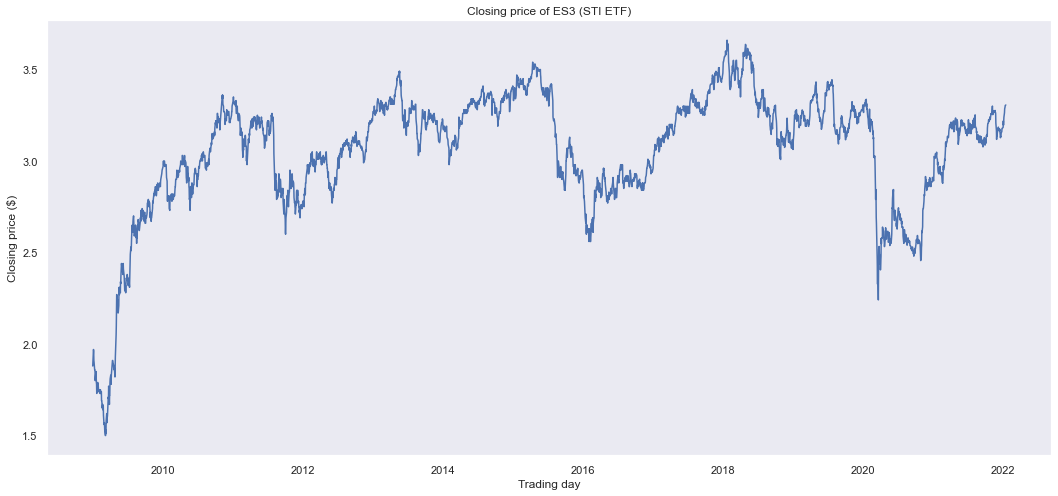

In [14]:
# plot closing price over entire dataset
plt.figure(figsize=(18, 8))
plt.plot(train_data.Close)
plt.title('Closing price of ES3 (STI ETF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving average to identify trends

In [15]:
#helper function to plot moving average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(18,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

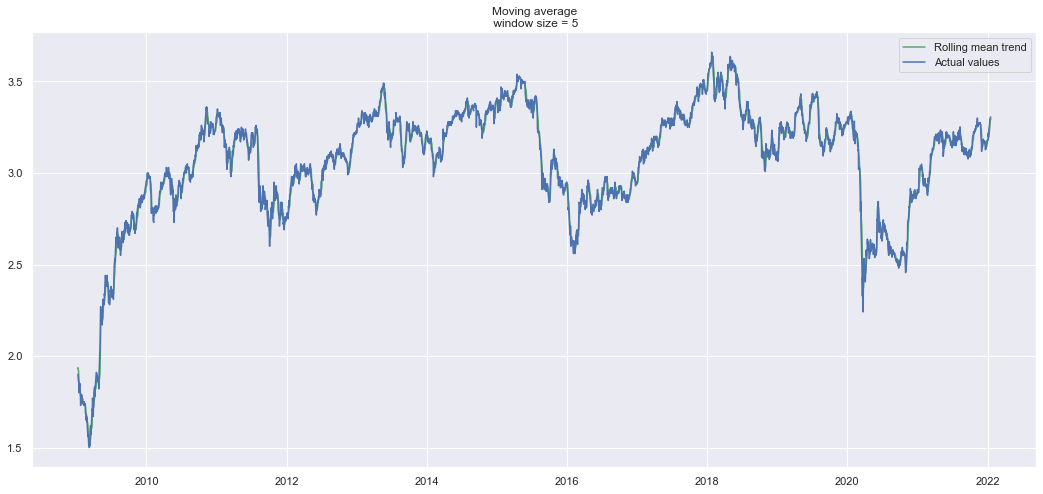

In [18]:
#Smooth by the previous 5 days (by week)
plot_moving_average(train_data.Close, 5)
#still too close to actual values

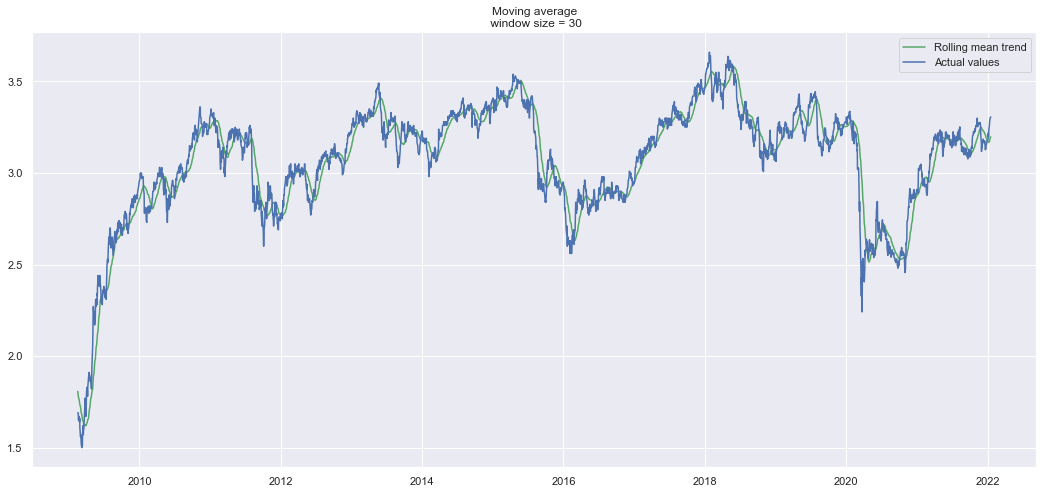

In [19]:
#Smooth by the previous month (30 days)
plot_moving_average(train_data.Close, 30)

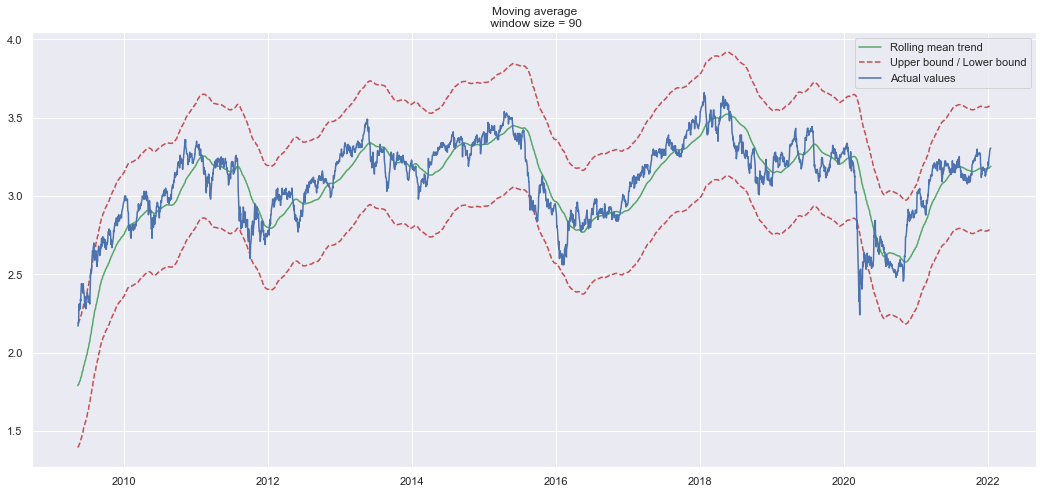

In [20]:
#Smooth by previous quarter (90 days)
plot_moving_average(train_data.Close, 90, plot_intervals=True)
#increasing trend at the end

### Exponential smoothing

In [21]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [22]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(18, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

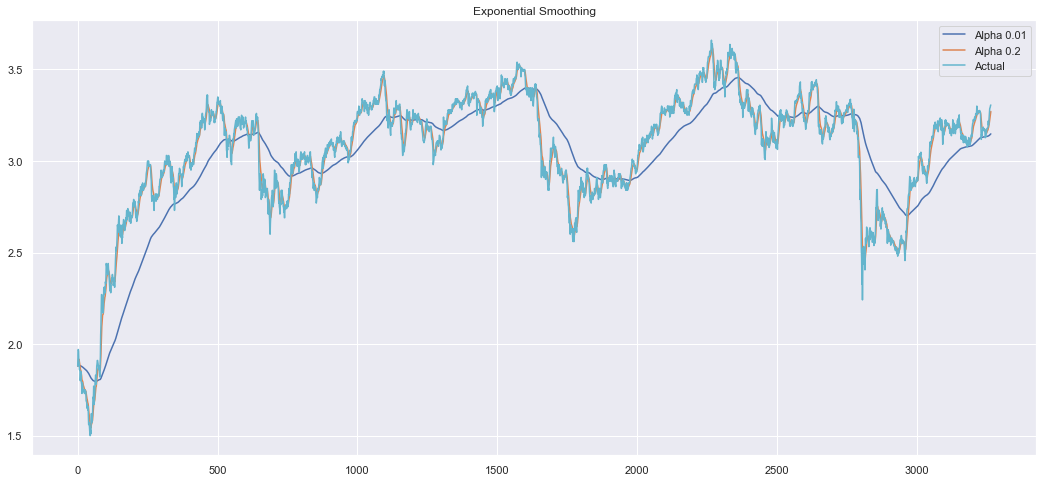

In [23]:
plot_exponential_smoothing(train_data.Close, [0.01, 0.2])
#the smaller the alpha, the smoother the curve

### Double exponential smoothing 

In [24]:
#to find trends in time series
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [25]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(18, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

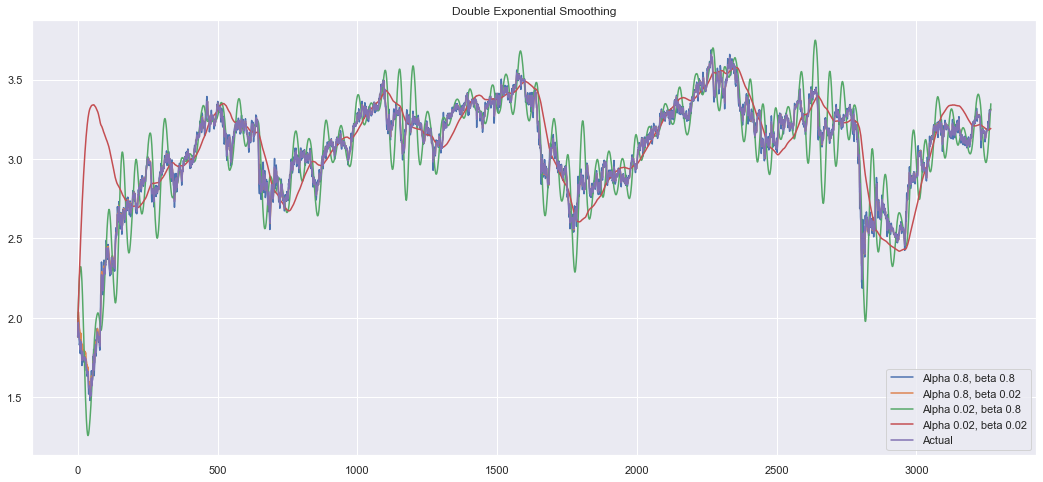

In [26]:
plot_double_exponential_smoothing(train_data.Close, alphas=[0.8, 0.02], betas=[0.8, 0.02])
#red line with the lowest alpha and beta show a clear trending pattern
#trend is not clearly due to the time frame, for a longer time frame, prices look like it is dipping. However if the time frame is shorted with only the last few days, ES3 looks to be on the upbound.
#moving average and exponential smoothing looks quite similar when compared to each other. A probable reason for that is that ES3 does not exhibit much volatility such that a more lagged moving average is good enough compared to a more responsive (or places higher emphasis on recent data) estimate.

## Stationarity 

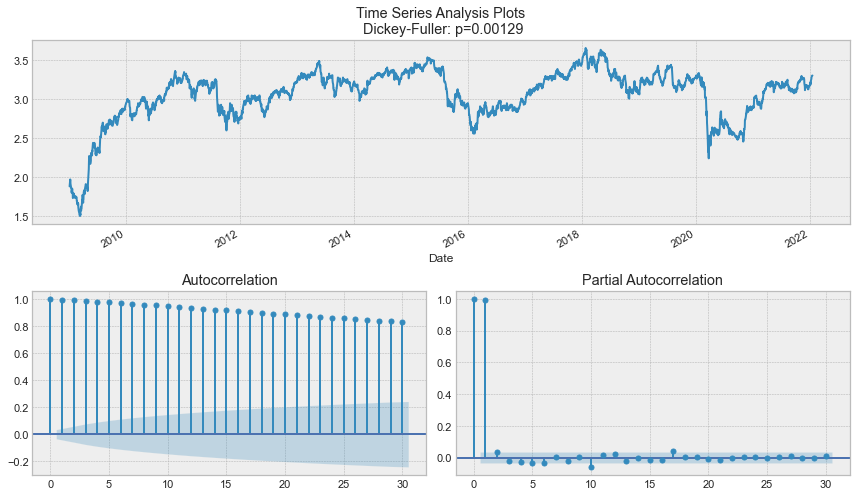

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(train_data.Close, lags=30)
#Dickey-Fuller (DF) test does not reject the null hypothesis of a unit root present in the AR model. The stock price has a constand mean and variance? This could be becase STI is not as volatile as other markets. We also know from the above charts that STI does have a clear trend.

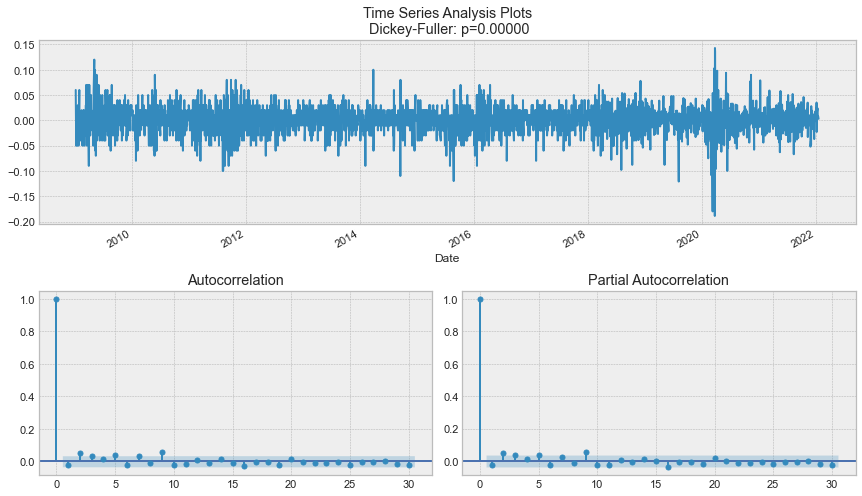

In [28]:
data_diff = train_data.Close - train_data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

## SARIMA

In [29]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [30]:
#running this takes 2h
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(train_data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

In [31]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train_data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                  Close   No. Observations:                 3266
Model:             SARIMAX(3, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood                7235.404
Date:                                Mon, 24 Jan 2022   AIC                         -14452.808
Time:                                        12:00:08   BIC                         -14398.002
Sample:                                             0   HQIC                        -14433.177
                                               - 3266                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0039      1.040     -0.004      0.997      -2.042       2.034
ar.

In [42]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    train_data = series.copy().rename(columns = {'CLOSE': 'actual'})
    train_data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    train_data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=train_data.shape[0], end=train_data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(train_data['actual'][s+d:], train_data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(train_data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(train_data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
fit_model = best_model.predict(start=train_data.Close.shape[0], end=train_data.Close.shape[0] + 5)
print(fit_model)
print(mean_absolute_percentage_error(data1.Close[s+d:], best_model.fittedvalues[s+d:]))

3266    3.306902
3267    3.306606
3268    3.308066
3269    3.309764
3270    3.310412
3271    3.310195
Name: predicted_mean, dtype: float64
0.6523029266720248


In [71]:
comparison = pd.DataFrame({'actual': [3.303,3.306,3.310,3.308,3.318,3.330],
                          'predicted': [3.307,3.307,3.308,3.31,3.31,3.31]}, 
                          index = pd.date_range(start='2022-01-17', periods=6,))

In [72]:
comparison.head(6)

,actual,predicted
2022-01-17,3.303,3.307
2022-01-18,3.306,3.307
2022-01-19,3.310,3.308
2022-01-20,3.308,3.310
2022-01-21,3.318,3.310
2022-01-22,3.330,3.310


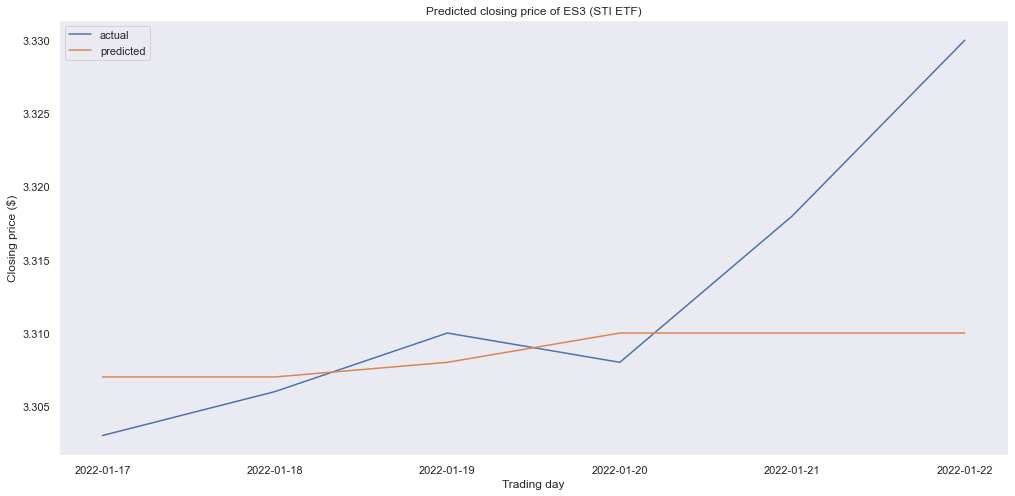

In [78]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual,label='actual')
plt.plot(comparison.predicted,label='predicted')
plt.title('Predicted closing price of ES3 (STI ETF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

## Conclusion

In [84]:
# The mean absolute percentage error of 0.6523 indicates a decent model. During the prediction pharse, SARIMAX is able to prdict the general trend of where the stock price is going to be, however it will not capture the peaks and troughs of the actual dataset. Improvements could be made using prophet model by facebook and LSTM.

In [ ]:
# Apologies for the late submission. Maximising SARIMAX took too long to run, and I also had issues installing tensorflow and keras due to python 3.8 incompatibily. I am still looking to solve this issue.